# Cavern storage capacity for variable heights

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import capacity as cap
from h2ss import compare
from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

In [5]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

In [6]:
# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [7]:
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"net_height": 85, "min_depth": 500, "max_depth": 2000},
)

## Generate caverns

In [8]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
)

In [9]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [10]:
# label caverns by depth and heights
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [11]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 979
------------------------------------------------------------
Excluding salt formation edges...
Number of potential caverns: 945
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 470
Caverns excluded: 50.26%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 399
Caverns excluded: 57.78%
------------------------------------------------------------


## Capacity

### Cavern volume

In [12]:
caverns["cavern_total_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"]
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_total_volume"]
)

### Mid-point temperature

In [13]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [14]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(
    thickness_overburden=caverns["TopDepthSeabed"],
    depth_water=-caverns["Bathymetry"],
)

### Hydrogen gas density

In [15]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [16]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [17]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [18]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [19]:
caverns.drop(
    columns=[
        "x",
        "y",
        "BaseDepth",
        "TopDepth",
        "TopTWT",
        "BaseDepthSeabed",
    ]
).describe()

,Thickness,TopDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_height,cavern_depth,cavern_total_volume,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,3.990000e+02,3.990000e+02,399.000000,3.990000e+02,3.990000e+02,399.000000,399.000000,3.990000e+02,3.990000e+02,3.990000e+02,399.000000,399.000000
mean,392.692637,1053.269888,-47.942230,0.621016,247.034600,118.839599,1133.269888,5.573190e+05,3.901233e+05,327.875863,7.908089e+06,2.108824e+07,5.510392,13.635218,3.223334e+06,2.188069e+06,5.411404e+06,107.408666,0.598017
std,69.115380,379.820048,13.520585,0.049226,66.379385,52.274636,379.820048,2.966325e+05,2.076428e+05,14.383080,2.682581e+06,7.153550e+06,1.566549,3.614652,1.926809e+06,1.332625e+06,3.258448e+06,64.205544,0.008121
min,316.764900,421.304826,-76.084564,0.554740,175.722230,85.000000,501.304826,3.652962e+05,2.557073e+05,303.542681,3.425755e+06,9.135347e+06,2.682620,6.922279,1.084112e+06,6.859656e+05,1.770077e+06,36.125011,0.581349
25%,347.146400,735.556125,-60.474541,0.582848,202.333742,85.000000,815.556125,3.652962e+05,2.557073e+05,315.547169,5.644452e+06,1.505187e+07,4.204461,10.639678,1.769056e+06,1.164523e+06,2.933579e+06,58.948877,0.592058
50%,375.021400,1030.925564,-43.752434,0.608638,228.252174,85.000000,1110.925564,3.652962e+05,2.557073e+05,326.985424,7.779068e+06,2.074418e+07,5.500506,13.687629,2.443959e+06,1.675476e+06,4.120121e+06,81.438139,0.598092
75%,417.471050,1318.617475,-41.456015,0.647911,270.484140,155.000000,1398.617475,7.625113e+05,5.337579e+05,338.099546,9.783203e+06,2.608854e+07,6.661414,16.329301,4.521066e+06,3.052067e+06,7.573133e+06,150.651957,0.604832
max,822.710300,1900.680682,-18.320551,0.750000,617.032725,311.000000,1980.680682,1.647734e+06,1.153413e+06,359.019276,1.382934e+07,3.687824e+07,8.706567,20.796696,1.138274e+07,7.872472e+06,1.925521e+07,379.298161,0.612466


In [20]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         1.556592e+08
working_mass          1.286110e+09
capacity              4.285606e+04
mass_operating_min    8.730397e+08
mass_operating_max    2.159150e+09
dtype: float64

In [21]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
compare.electricity_demand_ie(caverns_df=caverns)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 35.13–51.02%


In [22]:
# total capacity at various depth/height combinations
s = caverns.groupby(["depth", "cavern_height", "halite"], sort=False)[
    ["capacity"]
].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
depth         cavern_height halite                           
1,000 - 1,500 311.0         Rossall    3613.977881   8.432829
              155.0         Rossall   12006.087146  28.014913
              85.0          Rossall    6356.078343  14.831225
500 - 1,000   311.0         Rossall    1580.239728   3.687319
              155.0         Rossall    2408.323030   5.619563
1,500 - 2,000 155.0         Rossall    5229.407317  12.202259
500 - 1,000   85.0          Rossall    2572.953053   6.003709
1,500 - 2,000 85.0          Rossall    1839.994778   4.293430
1,000 - 1,500 155.0         Preesall    138.531699   0.323249
              85.0          Preesall     70.172538   0.163740
500 - 1,000   155.0         Preesall    908.967039   2.120977
              85.0          Preesall   1417.392302   3.307332
1,500 - 2,000 85.0          Preesall   1375.233638   3.208960
1,000 - 1,500 155.0         Fylde       481.957684   1.124596
              85.0          Fylde       733.310380   1.711101
1,500 - 2,000 155.0         Fylde       201.300795   0.469714
500 - 1,000   155.0         Fylde       107.786410   0.251508
              85.0          Fylde      1419.559349   3.312389
1,500 - 2,000 85.0          Fylde       394.784768   0.921188

In [23]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",23400.115672
"1,500 - 2,000",9040.721295
"500 - 1,000",10415.220910


In [24]:
s.groupby("cavern_height").sum()[["capacity"]]

,capacity
cavern_height,
85.0,16179.479149
155.0,21482.361120
311.0,5194.217609


In [25]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,3338.699386
Preesall,3910.297216
Rossall,35607.061276


In [26]:
# number of caverns
s = caverns.groupby(["depth", "cavern_height", "halite"], sort=False)[
    ["capacity"]
].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

capacity          %
depth         cavern_height halite                       
1,000 - 1,500 311.0         Rossall         11   2.756892
              155.0         Rossall         75  18.796992
              85.0          Rossall         86  21.553885
500 - 1,000   311.0         Rossall          6   1.503759
              155.0         Rossall         22   5.513784
1,500 - 2,000 155.0         Rossall         27   6.766917
500 - 1,000   85.0          Rossall         54  13.533835
1,500 - 2,000 85.0          Rossall         19   4.761905
1,000 - 1,500 155.0         Preesall         1   0.250627
              85.0          Preesall         1   0.250627
500 - 1,000   155.0         Preesall         8   2.005013
              85.0          Preesall        29   7.268170
1,500 - 2,000 85.0          Preesall        14   3.508772
1,000 - 1,500 155.0         Fylde            3   0.751880
              85.0          Fylde           10   2.506266
1,500 - 2,000 155.0         Fylde            1   0.250627
500 - 1,000   155.0         Fylde            1   0.250627
              85.0          Fylde           27   6.766917
1,500 - 2,000 85.0          Fylde            4   1.002506

In [27]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",187
"1,500 - 2,000",65
"500 - 1,000",147


In [28]:
s.groupby("cavern_height").sum()[["capacity"]]

,capacity
cavern_height,
85.0,244
155.0,138
311.0,17


In [29]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,46
Preesall,53
Rossall,300


## Map

In [92]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [119]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf, top_depth=True, fontsize=11.5):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis1 = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles1 = []
    classes = sorted(list(int(x) for x in caverns["cavern_height"].unique()))

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis1,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis1, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis1,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis1,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles1.append(
        mpatches.Patch(label="Cavern height [m]", visible=False)
    )

    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    for n, y in enumerate(colours):
        c = cavern_df[cavern_df["cavern_height"] == classes[n]]
        label1 = f"{classes[n]}"
        if top_depth:
            for df, markersize in zip(
                [
                    c[c["depth"] == "500 - 1,000"],
                    c[c["depth"] == "1,000 - 1,500"],
                    c[c["depth"] == "1,500 - 2,000"],
                ],
                [30, 60, 30],
            ):
                if len(df) > 0:
                    df.centroid.plot(
                        ax=axis1,
                        zorder=3,
                        linewidth=0,
                        marker=".",
                        markersize=markersize,
                        color=sns.color_palette("flare", 256)[y],
                    )
        else:
            gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
                ax=axis1,
                scheme="UserDefined",
                classification_kwds={"bins": classes[1:]},
                column="cavern_height",
                zorder=3,
                marker=".",
                cmap="flare",
                markersize=40,
            )
        legend_handles1.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=label1
            )
        )

    if top_depth:
        legend_handles1.append(
            mpatches.Patch(label="Cavern top depth [m]", visible=False)
        )
        for markersize, label1 in zip(
            [6, 3], ["1,000–1,500", "500–1,000 or \n1,500–2,000"]
        ):
            legend_handles1.append(
                Line2D(
                    [0],
                    [0],
                    marker=".",
                    linewidth=0,
                    label=label1,
                    color="darkslategrey",
                    markersize=markersize,
                )
            )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    basemap = cx.providers.CartoDB.VoyagerNoLabels
    cx.add_basemap(
        axis1, crs=rd.CRS, source=basemap, zoom=12, attribution=False
    )
    axis1.text(
        shape.bounds["minx"][0] - 800,
        shape.bounds["miny"][0] - 800,
        basemap["attribution"],
        fontsize=10,
    )

    axis1.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize, "rotation": 90},
        xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        yformatter=LatitudeFormatter(auto_hide=False, dms=True),
    )
    axis1.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles1,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", "fig_caverns_capacity_ntg_height.jpg"),
        format="jpg",
        dpi=600,
    )
    plt.show()

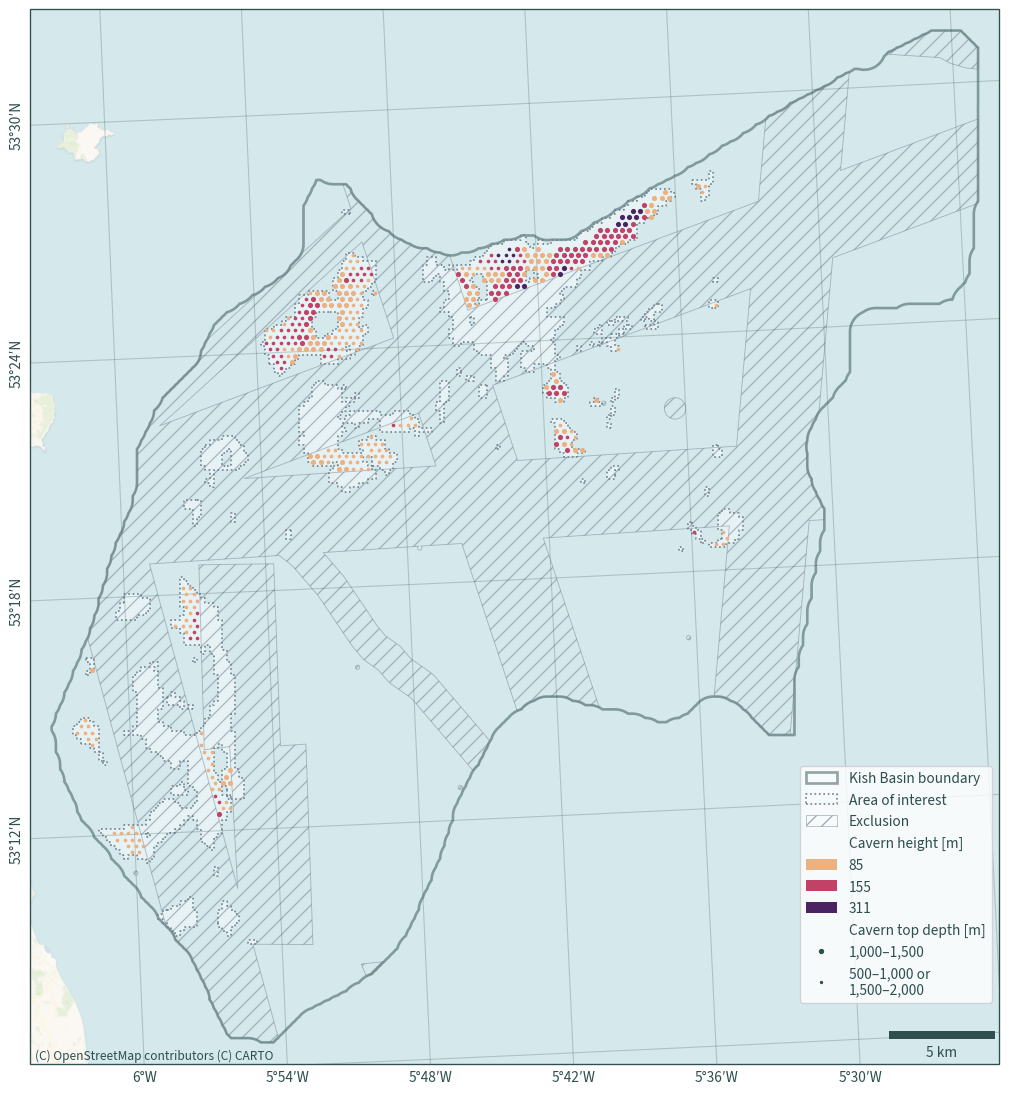

In [120]:
plot_map_alt(ds, caverns, zones)